In [1]:
import os

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import PIL.ImageOps
from sklearn.model_selection import train_test_split
from sklearn import datasets

import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.manifold import MDS
from sklearn.manifold import Isomap 
from sklearn.manifold import LocallyLinearEmbedding as LLE
from sklearn.manifold import SpectralEmbedding as SE
from sklearn.random_projection import GaussianRandomProjection as GRP
import umap

import matplotlib.pyplot as plt
import seaborn as sns

import ray 


In [2]:
ray.init()


2020-03-10 15:49:57,239	INFO resource_spec.py:216 -- Starting Ray with 3.66 GiB memory available for workers and up to 1.86 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


{'node_ip_address': '129.69.205.59',
 'redis_address': '129.69.205.59:33507',
 'object_store_address': '/tmp/ray/session_2020-03-10_15-49-57_225866_34218/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-10_15-49-57_225866_34218/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2020-03-10_15-49-57_225866_34218'}

In [11]:
def flatten_image(data):
    d = data.shape
    #print(d)
    flat_data = data.flatten().reshape(d[0], np.product(d[1:]))
    #print(flat_data.shape)
    return flat_data
    

@ray.remote
def apply_dr(dr_name, file_name, perplexity = None, n_neighbors=None, min_dist=None, dataset_name = 'MNIST/', max_samples = 5000):
    
    df = pd.read_csv(file_name)

    y = df['labels']
    X = df.iloc[:,:-2]
        
    if df.shape[0]>max_samples:
        X_train, features, y_train, labels = train_test_split(X, y, test_size=5000, random_state=42, stratify=y)
    else: 
        X_train, features, y_train, labels = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)
    
    
    file_name = "{dr_name}{perp}{neigh}{mindist}".format(dr_name = dr_name, 
                                         perp = "_p" + str(perplexity) if perplexity is not None else "",
                                         neigh = "_n" + str(n_neighbors) if n_neighbors is not None else "",
                                         mindist = "_d" + str(min_dist) if min_dist is not None else "")
    
    

    
    ## check if files exist
    print(file_name)
    if os.path.exists(dataset_name + '/data/' + file_name + '.csv'):
        print('File was already calculated. Skipping ....')
        return
    ########
    
    ## apply dr
    if dr_name=='PCA':
        dr = PCA(n_components = 2)
        
    elif dr_name=='TSNE':
        dr = TSNE(n_components = 2, perplexity = perplexity, verbose = 3)
        
    elif dr_name=='ISM':
        dr = Isomap(n_components = 2, n_neighbors = n_neighbors)
        
    elif dr_name=='LLE':
        dr = LLE(n_components = 2, n_neighbors = n_neighbors)
        
    elif dr_name=='SE':
        dr = SE(n_components = 2, n_neighbors = n_neighbors)
        
    elif dr_name=='UMAP':
        dr = umap.UMAP(n_components = 2, n_neighbors = n_neighbors, verbose=True, min_dist=min_dist)
        
    elif dr_name=='GRP':
        dr = GRP(n_components = 2)
        
    dr_data = dr.fit_transform(features)
    dr_data = pd.DataFrame(dr_data, columns=['{}_1'.format(dr_name),'{}_2'.format(dr_name)])
    ###########
    
    ## save stuff
    if labels is not None:
        dr_data['labels'] = list(labels)
        fig, ax = plt.subplots()
        sns.scatterplot(dr_data['{}_1'.format(dr_name)], dr_data['{}_2'.format(dr_name)], hue = dr_data['labels'] )
        plt.savefig(dataset_name + '/figures/' + file_name +'.pdf')
    
    
    dr_data.to_csv(dataset_name + '/data/' +file_name + '.csv', index=False)
    print('---------Finished: {}-----------'.format(file_name))
    ##########
    
    return 
    

            

def load_and_combine(folder):
    files = os.listdir(folder)
    datasets = []
    for f in files:
        datasets.append(pd.read_csv(folder+files))
    
    return pd.concat(datasets, axis=1)


(60000, 28, 28)


(-0.5, 27.5, 27.5, -0.5)

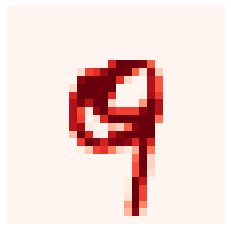

In [5]:
#load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)
x_train = flatten_image(x_train)
x_test = flatten_image(x_test)


image_index = 4444
plt.imshow(x_test[image_index].reshape(28, 28), cmap='Reds')
plt.axis('off')

# save_images(x_test, y_test, name='MNIST')


(10000, 784)


(-0.5, 27.5, 27.5, -0.5)

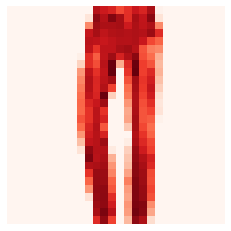

In [6]:
# load fashion MNIST
x_test = pd.read_csv('fashionmnist/original_files/fashion-mnist_test.csv')


y_test = x_test['label']
x_test = x_test.iloc[:,1:]
x_test = np.array(x_test)
print(x_test.shape)

image_index = 1
plt.imshow(x_test[image_index].reshape(28, 28), cmap='Reds')
plt.axis('off') 


In [13]:
# apply all these drs

files = os.listdir()
files = ['fashionmnist', 'pets', 'oxford_buildings','dogs','cinic10', 'caltech', 'paris_buildings']
print(files)
for f in files:
    if os.path.isdir(f) and not f.startswith('.') and not f.startswith('_') and not f.startswith('MNIST'):
        print(f)
        for dr_name in ['PCA','TSNE', 'ISM', 'LLE', 'UMAP', 'SE', 'GRP']:
            print(dr_name)
            if dr_name in ['PCA','GRP']:
                dr_data = apply_dr.remote(dr_name, f+'/flat_img_50_1.csv', dataset_name = f)
            elif dr_name == 'TSNE':
                for p in [5,10,30,50,150,100]:
                    #print(p)
                    dr_data = apply_dr.remote(dr_name,f+'/flat_img_50_1.csv', perplexity=p, dataset_name = f)   
            else:
                for n in [2,3,5,7,10,15]:
                    #print(n)
                    if dr_name == 'UMAP':
                        for d in [0.05, 0.1, 0.25, 0.5, 0.8, 0.99]:
                            dr_data = apply_dr.remote(dr_name,f+'/flat_img_50_1.csv', n_neighbors=n, min_dist=d, dataset_name = f)
                    else:
                        dr_data = apply_dr.remote(dr_name, f+'/flat_img_50_1.csv', n_neighbors=n, dataset_name = f)
            print('----')


['fashionmnist', 'pets', 'oxford_buildings', 'dogs', 'cinic10', 'caltech', 'paris_buildings']
fashionmnist
PCA
----
TSNE
5
10
30
50
150
100
----
ISM
2
3
5
7
10
15
----
LLE
2
3
5
7
10
15
----
UMAP
2
3
5
7
10
15
----
SE
2
3
5
7
10
15
----
GRP
----
pets
PCA
----
TSNE
5
10
30
50
150
100
----
ISM
2
3
5
7
10
15
----
LLE
2
3
5
7
10
15
----
UMAP
2
3
5
7
10
15
----
SE
2
3
5
7
10
15
----
GRP
----
oxford_buildings
PCA
----
TSNE
5
10
30
50
150
100
----
ISM
2
3
5
7
10
15
----
LLE
2
3
5
7
10
15
----
UMAP
2
3
5
7
10
15
----
SE
2
3
5
7
10
15
----
GRP
----
dogs
PCA
----
TSNE
5
10
30
50
150
100
----
ISM
2
3
5
7
10
15
----
LLE
2
3
5
7
10
15
----
UMAP
2
3
5
7
10
15
----
SE
2
3
5
7
10
15
----
GRP
----
cinic10
PCA
----
TSNE
5
10
30
50
150
100
----
ISM
2
3
5
7
10
15
----
LLE
2
3
5
7
10
15
----
UMAP
2
3
5
7
10
15
----
SE
2
3
5
7
10
15
----
GRP
----
caltech
PCA
----
TSNE
5
10
30
50
150
100
----
ISM
2
3
5
7
10
15
----
LLE
2
3
5
7
10
15
----
UMAP
2
3
5
7
10
15
----
SE
2
3
5
7
10
15
----
GRP
----
paris_buildings


(pid=34243) [t-SNE] Iteration 100: error = 62.6310310, gradient norm = 0.0032633 (50 iterations in 8.669s)
(pid=34240) [t-SNE] Iteration 200: error = 81.6830826, gradient norm = 0.0100679 (50 iterations in 5.885s)
(pid=34242) [t-SNE] Iteration 200: error = 73.2679138, gradient norm = 0.0022272 (50 iterations in 6.067s)
(pid=34245) [t-SNE] Iteration 150: error = 65.0142746, gradient norm = 0.0003151 (50 iterations in 7.239s)
(pid=34238)           ISM_1         ISM_2
(pid=34238) 0 -12188.063727  -1924.472438
(pid=34238) 1 -11383.837347  -5179.952782
(pid=34238) 2   1863.455480   8781.486941
(pid=34238) 3    -44.814736  11955.001501
(pid=34238) 4   1627.154210  -1317.965977
(pid=34239) [t-SNE] Iteration 250: error = 85.5374527, gradient norm = 0.0127076 (50 iterations in 5.813s)
(pid=34239) [t-SNE] KL divergence after 250 iterations with early exaggeration: 85.537453
(pid=34241) [t-SNE] Iteration 200: error = 69.6861420, gradient norm = 0.0017288 (50 iterations in 6.560s)
(pid=34240) [t-S

(pid=34243) [t-SNE] Iteration 450: error = 0.8779562, gradient norm = 0.0000977 (50 iterations in 7.366s)
(pid=34241) [t-SNE] Iteration 600: error = 1.1820607, gradient norm = 0.0000893 (50 iterations in 5.808s)
(pid=34239) [t-SNE] Iteration 700: error = 1.6652792, gradient norm = 0.0001895 (50 iterations in 5.205s)
(pid=34242) [t-SNE] Iteration 650: error = 1.3145156, gradient norm = 0.0001024 (50 iterations in 5.681s)
(pid=34240) [t-SNE] Iteration 700: error = 1.5493298, gradient norm = 0.0001316 (50 iterations in 5.328s)
(pid=34245) [t-SNE] Iteration 550: error = 0.9804574, gradient norm = 0.0000746 (50 iterations in 6.496s)
(pid=34239) [t-SNE] Iteration 750: error = 1.6369426, gradient norm = 0.0001702 (50 iterations in 5.251s)
(pid=34241) [t-SNE] Iteration 650: error = 1.1728897, gradient norm = 0.0000804 (50 iterations in 5.689s)
(pid=34243) [t-SNE] Iteration 500: error = 0.8665431, gradient norm = 0.0000752 (50 iterations in 7.427s)
(pid=34242) [t-SNE] Iteration 700: error = 1.3

(pid=34241)       TSNE_1     TSNE_2  labels
(pid=34241) 0 -60.523758   8.326879       8
(pid=34241) 1 -37.006908 -33.731403       9
(pid=34241) 2   9.685121  33.103539       3
(pid=34241) 3  -8.514486  50.875778       1
(pid=34241) 4  12.690995 -11.937288       6
(pid=34241) (5000, 3)
(pid=34243) [t-SNE] Iteration 800: error = 0.8528445, gradient norm = 0.0000334 (50 iterations in 6.337s)
(pid=34241) LLE_n3
